## American Put Options with the Binomial Asset Pricing Model


Implementation of a simple slow and fast binomial pricing model in python. 
We will treat binomial tree as a network with nodes (i,j) with i representing the time steps and j representing the number of ordered price outcome, lowest – or bottom of tree – to highest.

>.american_tree_slow

>.american_tree_fast

#### Generic timing wrapper function
We will use this to benchmark the two binomial models.

In [47]:
# Ignore all warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
import numpy as np
from functools import wraps
from time import time
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

#### Binomial Tree Representation

Stock tree can be represented using nodes (i,j) and intial stock price S0
$S_{i,j}=S_0u^jd^{i−j}$

$C_{i,j}$ represents contract price at each node (i,j). Where C_{N,j} represents final payoff function that we can define.

#### American Option Characteristics
For an American Put Option:

if $T=t_N$ then at the terminal nodes, $C_{jN}=(K−S^j_N)^+$

for all other parts of the tree at nodes (i,j)
– Max of exercise value or continuation/hold value
– $C^j_i=max((K−S^j_i)^+,e^{−rΔt}{q^j_iC^{j+1}_{i+1}+(1–q^j_i)C^{j−1}_{i−1}})$

American Tree Slow
Here we will use for loops to iterate through nodes j at each time step i.

In [4]:
# Initialise parameters
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # ensure recombining tree
opttype = 'P' # Option Type 'C' or 'P'

In [5]:
@timing 
def american_slow_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise stock prices at maturity
    S = np.zeros(N+1)
    for j in range(0, N+1):
        S[j] = S0 * u**j * d**(N-j)
        
    # option payoff 
    C = np.zeros(N+1)
    for j in range(0, N+1):
        if opttype == 'P':
            C[j] = max(0, K - S[j])
        else:
            C[j] = max(0, S[j] - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
            if opttype == 'P':
                C[j] = max(C[j], K - S)
            else:
                C[j] = max(C[j], S - K)
                
    return C[0]
american_slow_tree(K,T,S0,r,N,u,d,opttype='P')

func:'american_slow_tree' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0004 sec


4.654588754602527

#### American Tree Fast
Now we will vectorise out code using numpy arrays instead of for loops through j nodes.

In [8]:
@timing 
def american_fast_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise stock prices at maturity
    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        
    # option payoff 
    if opttype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]  # ? leave out the last one ?
        if opttype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
                
    return C[0]
american_fast_tree(K,T,S0,r,N,u,d,opttype='P')


func:'american_fast_tree' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0051 sec


4.654588754602527

#### Binomial Tree Slow vs Fast
Now we will compare runtimes for slow vs fast. Ignore option price changes as this is impacted with changing the time steps and keeping the u and d factors the same.


In [9]:
for N in [3,50, 100, 1000, 5000]:
    american_fast_tree(K,T,S0,r,N,u,d,opttype='P')
    american_slow_tree(K,T,S0,r,N,u,d,opttype='P')

func:'american_fast_tree' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0014 sec
func:'american_slow_tree' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0002 sec
func:'american_fast_tree' args:[(100, 1, 100, 0.06, 50, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0037 sec
func:'american_slow_tree' args:[(100, 1, 100, 0.06, 50, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0086 sec
func:'american_fast_tree' args:[(100, 1, 100, 0.06, 100, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0039 sec
func:'american_slow_tree' args:[(100, 1, 100, 0.06, 100, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0203 sec
func:'american_fast_tree' args:[(100, 1, 100, 0.06, 1000, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 0.0462 sec
func:'american_slow_tree' args:[(100, 1, 100, 0.06, 1000, 1.1, 0.9090909090909091), {'opttype': 'P'}] took: 1.6914 sec
func:'american_fast_tree' args:[(100, 1, 100, 0.06, 5000, 1.

## Dynamic Delta Hedging using Black-Scholes and Implied Volatility with the Newton-Raphson Method

### Dynamic Delta Hedging using Black-Scholes

In [32]:
#! pip install yfinance

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   28.299999   28.713333   28.114000   28.684000   28.684000   
2020-01-03   29.366667   30.266666   29.128000   29.534000   29.534000   
2020-01-06   29.364668   30.104000   29.333332   30.102667   30.102667   
2020-01-07   30.760000   31.441999   30.224001   31.270666   31.270666   
2020-01-08   31.580000   33.232666   31.215334   32.809334   32.809334   
...                ...         ...         ...         ...         ...   
2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2020-12-30  224.000000  232.199997  222.786

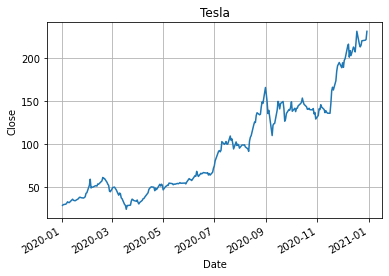

In [31]:
import locale
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import yfinance as yf
yf.pdr_override()


start_date = "2020-01-01"
end_date = "2020-12-31"
ticker = 'TSLA'
data = pdr.get_data_yahoo(ticker,start=start_date, end=end_date)
print(data)

close = data['Close']
ax = close.plot(title='Tesla')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
ax.grid()
plt.show()


#### Full worked example of the impact of delta hedging european options.

In [11]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

In [28]:
end = dt.datetime.now().strftime('%Y-%m-%d')
end

'2023-01-08'

[*********************100%***********************]  1 of 1 completed


(0.13952088057114728, 103.18000030517578)

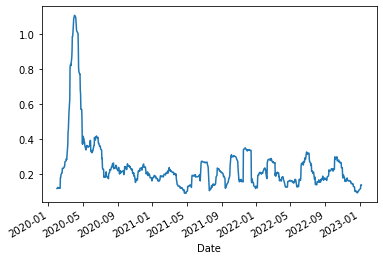

In [34]:
end_date = dt.datetime.now() # .strftime('%Y/%m/%d')
start_date = dt.datetime(2020,1,1) #.strftime('%Y/%m/%d')

try:
    df=pdr.get_data_yahoo(['CBA.AX'],start=start_date,end=end_date)
except ValueError:
    print("ValueError, trying again")

Close = df.Close
Close.tail()

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

In [38]:
#!pip install py_vollib

#### Implied Volatility with the Newton-Raphson Method

In [39]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess 

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

In [54]:
S0, K, T, r = 30, 28, 0.2, 0.025
market_price = 3.97
implied_vol_est = implied_vol(S0, K, T, r, market_price, flag='c')
print("Implied Volatility is : ", round(implied_vol_est,2)*100, "%")

Implied Volatility is :  54.0 %


In [40]:
S0 = 102
atm_options = [
[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3] 

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

In [41]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

#### Create functions to appply to pandas dataframes to calculate specific adjustments to be made during delta hedging.

In [42]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)
        
def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan
        
def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

#### Create Dynamic Hedging results dataframe to append rows to.

In [43]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

#### Create simulations of underlying stock prices using Geometric Brownian Motion (GBM) over time.

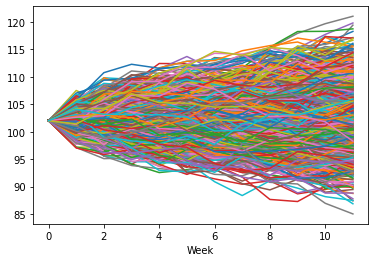

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.13,103.34,104.02,102.96,103.66,101.84,101.62,100.42,104.09,...,101.94,102.81,102.52,102.24,98.39,103.52,102.64,100.08,101.43,104.10
2,0.18,98.51,102.67,104.30,104.58,105.48,103.25,102.65,102.27,103.37,...,102.52,103.13,101.29,100.34,96.17,105.48,102.92,98.82,104.00,103.18
3,0.16,102.38,99.87,104.59,106.52,104.91,102.62,103.11,101.39,100.83,...,101.72,102.51,102.28,99.60,96.17,106.56,106.68,99.68,106.90,103.14
4,0.14,102.83,99.68,106.41,105.79,105.24,105.39,104.23,102.19,100.65,...,103.13,100.96,99.40,97.74,94.86,105.09,106.48,101.43,105.30,103.10
5,0.12,102.23,100.58,108.29,107.06,106.10,105.92,107.14,103.24,96.52,...,103.85,102.35,99.81,97.16,94.10,105.90,108.84,103.47,105.21,102.69
6,0.10,100.47,97.82,109.56,106.03,105.63,107.34,107.70,101.18,97.63,...,103.88,105.51,99.46,94.19,93.66,104.49,107.79,105.24,104.49,100.12
7,0.08,100.09,97.98,108.84,105.95,105.75,110.29,108.95,101.35,97.57,...,102.38,105.61,98.20,92.87,93.55,105.35,105.04,105.25,104.62,100.25
8,0.06,99.33,98.35,106.72,106.26,105.90,111.35,106.83,101.59,98.49,...,100.80,103.50,100.72,93.32,92.10,106.50,102.76,106.19,104.44,103.24


In [44]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)
    
St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

#### Build up delta hedging dataframe with specific factors: 
* delta
* total delta positions 
* number of adjustments 
* adjustment cashflow 
* interest on adjustments
 
We can then sum the columns over the 11 weeks of delta heding and calculate the carry on options, carry on stock, option p&l, stock p&l and adjustment p&l and interest earned on adjustments.

In [48]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']
    
    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])
#### we can compact the following code    
    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
            
    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        
    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)

#### Delta Hedging P&L 
Sum all contributions for Total Cashflow for each simulation

In [50]:
Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',] = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Dynamic hedging results,,,,,,,,,,,,,,,,,,,,,
Original Option P&L,-179.500000,258.500000,128.500000,-358.500000,-852.500000,-723.500000,84.500000,27.500000,258.500000,12.500000,...,258.500000,153.500000,258.500000,258.500000,258.500000,-799.500000,258.500000,-89.500000,-99.500000,-141.500000
Original Stock P&L,236.520000,-166.860000,70.200000,333.180000,599.940000,530.280000,93.960000,124.740000,-328.320000,132.840000,...,-34.560000,56.700000,-159.840000,-429.300000,-395.280000,571.320000,-200.340000,187.920000,193.320000,216.000000
Adjustment P&L,-117.790000,-60.600000,-181.690000,111.880000,335.890000,237.970000,-95.390000,-52.680000,67.310000,-164.260000,...,-116.190000,-97.760000,-24.970000,191.140000,116.470000,293.580000,-109.660000,-36.260000,-21.380000,-21.480000
Carry (interest) on options,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,...,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151
Carry (interest) on stock,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,...,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658
Interest on Adjustments,2.920000,10.370000,-11.120000,-12.940000,-12.490000,-12.030000,-11.060000,0.460000,10.380000,-0.070000,...,-2.250000,-4.000000,7.610000,14.720000,18.490000,-12.490000,-8.240000,-5.610000,-9.150000,-2.830000
TOTAL CASHFLOW,-80.861507,18.398493,-17.121507,50.608493,47.828493,9.708493,48.998493,77.008493,-15.141507,-42.001507,...,82.488493,85.428493,58.288493,12.048493,-24.831507,29.898493,-82.751507,33.538493,40.278493,27.178493


Visualise distributions
* hedging
* static hedge (at entry only)
* no delta heding

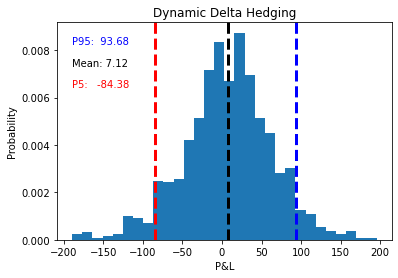

In [51]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

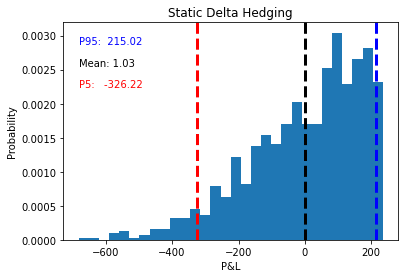

In [52]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

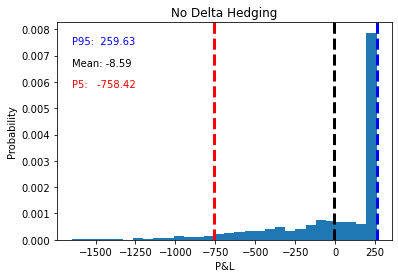

In [53]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

### Travelling Salesman Problem using Dynamic Programming

Quelle est la loi de la famille de vecteurs aléatoires
$
\biggl(
\begin{array}{c}
e^{-a t_{k+1}} \int_{t_k}^{t_{k+1}} e^{a u} dW_u
\\
W_{t_{k+1}} - W_{t_k}
\end{array}
\biggr)_{k = 0, \dots, N-1}$?

In [61]:
! pip uninstall xgboost

Found existing installation: xgboost 1.7.1
Uninstalling xgboost-1.7.1:
  Would remove:
    /Users/gnabeyeuemmanuel/opt/anaconda3/lib/python3.8/site-packages/xgboost-1.7.1.dist-info/*
    /Users/gnabeyeuemmanuel/opt/anaconda3/lib/python3.8/site-packages/xgboost/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
